# USD/THB Forecasting with XGBoost

Goal: Predict USD/THB exchange rate **30 days ahead** using XGBoost regression model.

Dataset: FX features from PostgreSQL database (2020-2025)

In [1]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from datetime import datetime, timedelta

import project_paths
from database.save_db import get_engine
from models.train_xgboost import load_data, create_features, prepare_train_test, train_xgboost

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Data Loading & Overview

In [2]:
# Load data from PostgreSQL
print("📥 Loading data from PostgreSQL database...")
df = load_data(start_date='2020-01-01')

print(f"\n✅ Dataset shape: {df.shape}")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")
print(f"📊 Total days: {len(df)}")
print(f"\n📋 Columns: {list(df.columns)}")

df.head()

📥 Loading data from PostgreSQL database...
✅ Loaded 2152 rows from database

✅ Dataset shape: (2152, 14)
📅 Date range: 2020-01-01 00:00:00 to 2025-11-21 00:00:00
📊 Total days: 2152

📋 Columns: ['usd_thb', 'dxy', 'gold', 'oil', 'vix', 'sp500', 'set_index', 'th_10y', 'th_cpi', 'th_policy_rate', 'us_10y', 'us_cpi', 'us_fed_rate', 'news_sentiment']


,usd_thb,dxy,gold,oil,vix,sp500,set_index,th_10y,th_cpi,th_policy_rate,us_10y,us_cpi,us_fed_rate,news_sentiment
date,,,,,,,,,,,,,,
2020-01-01,29.680000,96.849998,1524.500000,61.180000,12.47,3257.850098,1595.819946,1.460,1.05,1.25,1.88,259.127,1.55,959.0
2020-01-02,30.059999,96.849998,1524.500000,61.180000,12.47,3257.850098,1595.819946,1.460,1.05,1.25,1.88,259.127,1.55,1416.0
2020-01-03,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,1639.0
2020-01-04,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,733.0
2020-01-05,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,559.0


In [3]:
# Descriptive statistics
df.describe()

,usd_thb,dxy,gold,oil,vix,sp500,set_index,th_10y,th_cpi,th_policy_rate,us_10y,us_cpi,us_fed_rate,news_sentiment
count,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000
mean,33.561302,100.150502,2151.812311,70.230237,20.959633,4543.156575,1453.681147,2.113754,1.384526,1.343053,2.936055,293.252416,2.737937,1402.206784
std,1.952824,5.521410,579.564422,18.737683,7.833212,988.634956,159.558817,0.596993,2.580433,0.802441,1.410244,22.686021,2.233628,982.142734
min,29.680000,89.440002,1477.300049,-37.630001,11.860000,2237.399902,1024.459961,0.860000,-3.440000,0.500000,0.520000,255.802000,0.050000,0.000000
25%,32.270000,96.037500,1793.649963,61.900000,15.887500,3900.860107,1328.530029,1.570000,-0.470000,0.500000,1.530000,270.710000,0.090000,698.500000
50%,33.520000,100.860001,1918.000000,71.809998,19.080000,4369.709961,1469.589966,2.200000,0.620000,1.250000,3.530000,298.808000,4.090000,1133.000000
75%,34.987000,104.279999,2340.950012,80.277502,24.120000,5282.700195,1592.152466,2.570000,2.670000,2.250000,4.220000,313.140000,4.830000,1950.250000
max,38.299999,114.110001,4336.399902,123.699997,82.690002,6890.890137,1713.199951,3.390000,7.860000,2.500000,4.980000,324.368000,5.330000,12829.000000


In [4]:
# Missing values analysis
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    plt.figure(figsize=(10, 6))
    missing.plot(kind='barh', color='salmon')
    plt.title('Missing Values by Feature', fontsize=14, fontweight='bold')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('✅ No missing values!')

✅ No missing values!


## 2. Exploratory Data Analysis

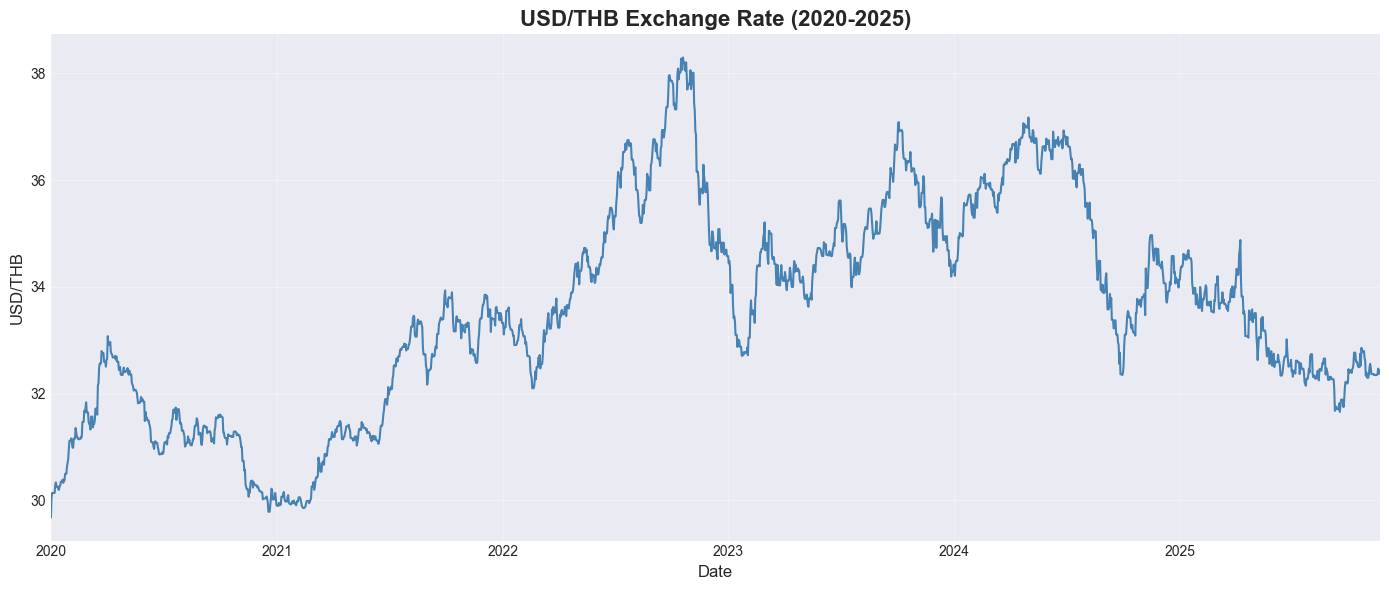


💵 Latest USD/THB rate: 32.4400 (as of 2025-11-21)


In [5]:
# USD/THB time series
fig, ax = plt.subplots(figsize=(14, 6))
df['usd_thb'].plot(ax=ax, linewidth=1.5, color='steelblue')
ax.set_title('USD/THB Exchange Rate (2020-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('USD/THB', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show latest rate
latest_rate = df['usd_thb'].iloc[-1]
latest_date = df.index[-1]
print(f"\n💵 Latest USD/THB rate: {latest_rate:.4f} (as of {latest_date.date()})")

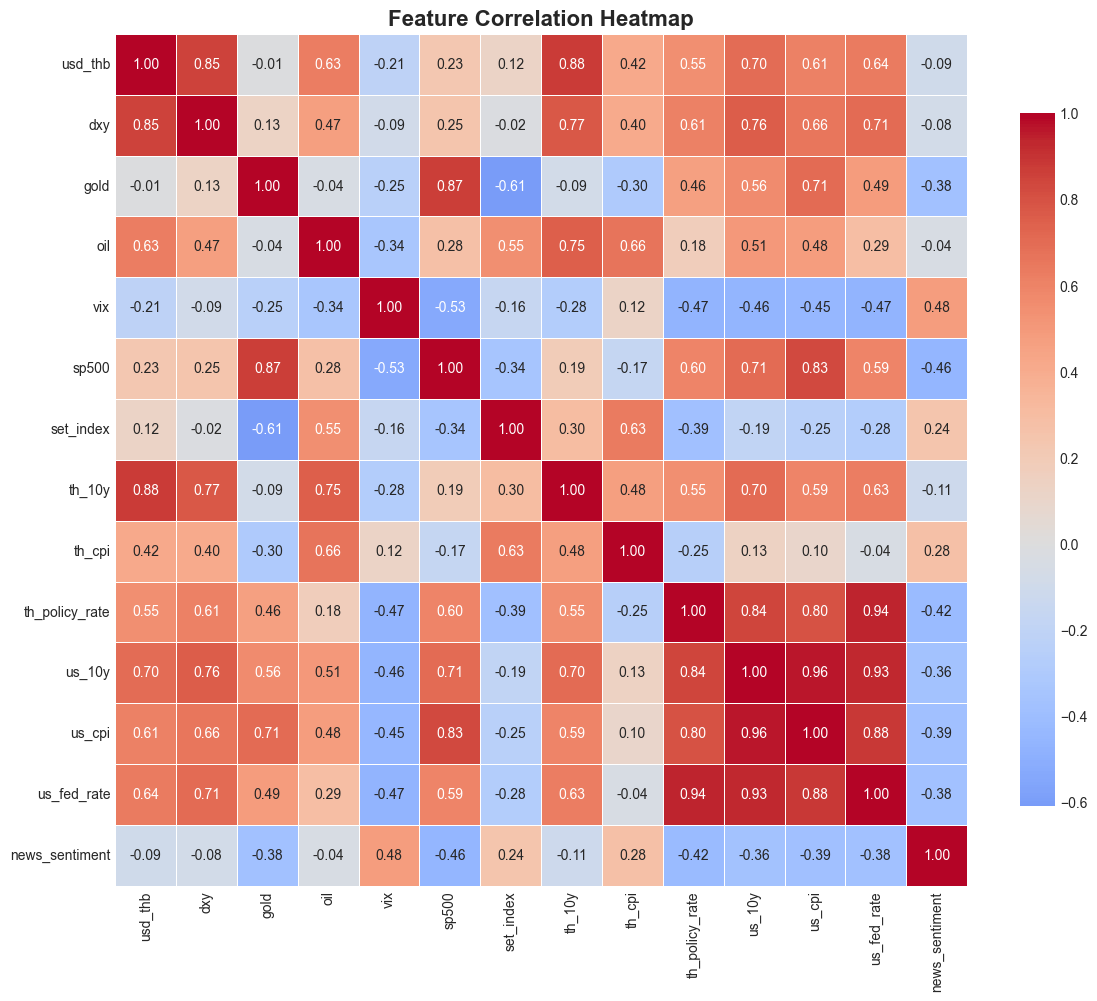

In [6]:
# Correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

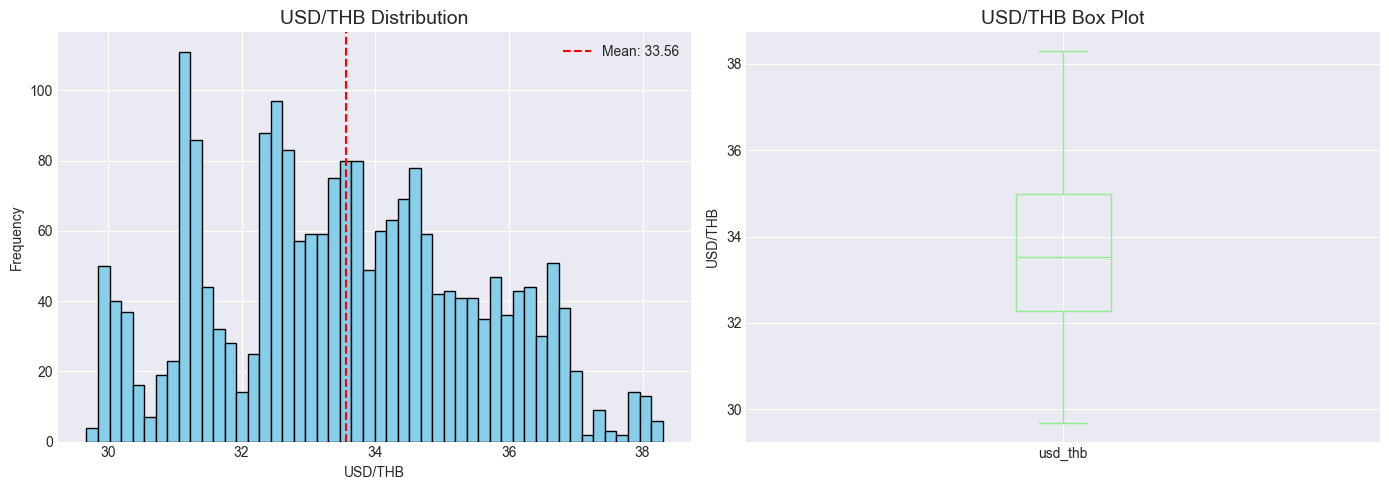

In [7]:
# USD/THB distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
df['usd_thb'].hist(bins=50, ax=axes[0], edgecolor='black', color='skyblue')
axes[0].set_title('USD/THB Distribution', fontsize=14)
axes[0].set_xlabel('USD/THB')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['usd_thb'].mean(), color='red', linestyle='--', label=f'Mean: {df["usd_thb"].mean():.2f}')
axes[0].legend()

# Box plot
df['usd_thb'].plot(kind='box', ax=axes[1], color='lightgreen')
axes[1].set_title('USD/THB Box Plot', fontsize=14)
axes[1].set_ylabel('USD/THB')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [8]:
# Create features
print("🔧 Creating features (lags, rolling stats, returns)...")
df_features = create_features(df, target_shift=30)

print(f"\n✅ Features created: {len(df_features.columns)}")
print(f"📊 Rows after feature engineering: {len(df_features)}")
print(f"🗑️ Rows dropped (due to 30-day forecast shift): {len(df) - len(df_features)}")

🔧 Creating features (lags, rolling stats, returns)...
✅ Created 67 features
   Rows after target creation: 2122

✅ Features created: 67
📊 Rows after feature engineering: 2122
🗑️ Rows dropped (due to 30-day forecast shift): 30


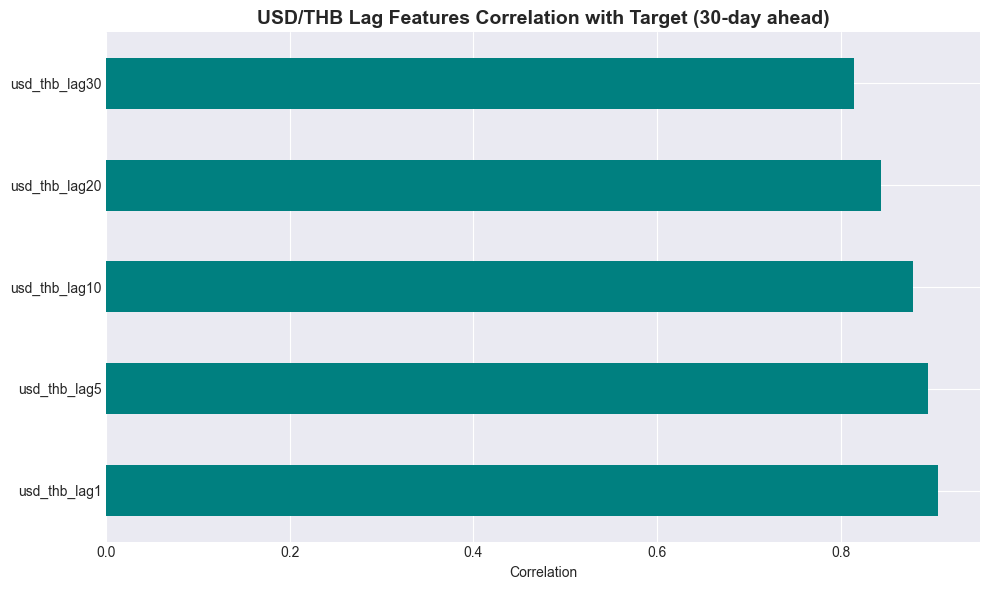

In [9]:
# Show lag features correlation with target
lag_cols = [col for col in df_features.columns if 'lag' in col and 'usd_thb' in col]
lag_corr = df_features[lag_cols + ['target']].corr()['target'].drop('target').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lag_corr.plot(kind='barh', color='teal')
plt.title('USD/THB Lag Features Correlation with Target (30-day ahead)', fontsize=14, fontweight='bold')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## 4. Model Training & Evaluation

In [10]:
# Prepare train/test split
print("📊 Splitting data into train/test sets (80/20)...")
X_train, X_test, y_train, y_test, feature_cols = prepare_train_test(df_features, test_size=0.2)

📊 Splitting data into train/test sets (80/20)...

📊 Train/Test Split:
   Train: 1673 samples (2020-01-31 00:00:00 to 2024-08-29 00:00:00)
   Test:  419 samples (2024-08-30 00:00:00 to 2025-10-22 00:00:00)
   Features: 65


In [11]:
# Train model
print("🚀 Training XGBoost model...")
model = train_xgboost(X_train, y_train, X_test, y_test)

🚀 Training XGBoost model...

🚀 Training XGBoost model...
[0]	validation_0-rmse:2.00501	validation_1-rmse:1.00316
[100]	validation_0-rmse:0.28854	validation_1-rmse:0.71417
[200]	validation_0-rmse:0.25185	validation_1-rmse:0.68676
[300]	validation_0-rmse:0.24890	validation_1-rmse:0.68505
[400]	validation_0-rmse:0.24877	validation_1-rmse:0.68485
[499]	validation_0-rmse:0.24727	validation_1-rmse:0.68375

📈 Model Performance:
   Train MAE:  0.1943
   Test MAE:   0.5798
   Train RMSE: 0.2473
   Test RMSE:  0.6838
   Test MAPE:  1.76%


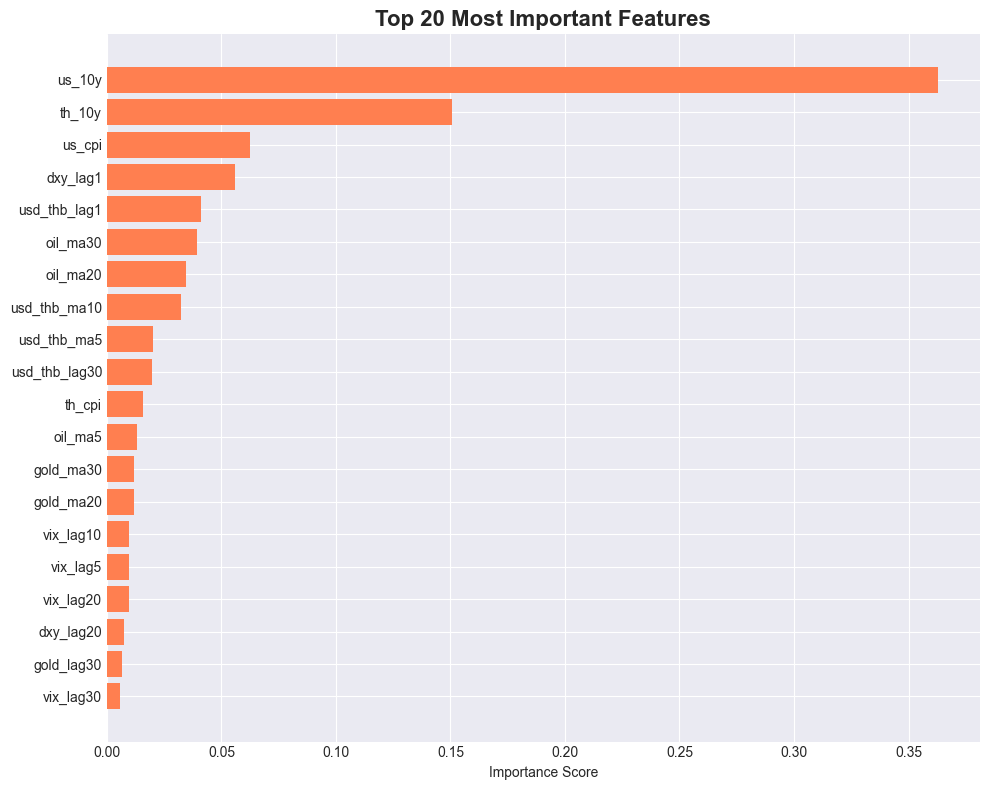


📊 Top 5 Most Important Features:
   us_10y: 0.3630
   th_10y: 0.1507
   us_cpi: 0.0624
   dxy_lag1: 0.0558
   usd_thb_lag1: 0.0411


In [12]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='coral')
plt.gca().invert_yaxis()
plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\n📊 Top 5 Most Important Features:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

In [13]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [14]:
# Model accuracy metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

# Calculate R² score
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("="*60)
print("📊 MODEL PERFORMANCE METRICS")
print("="*60)
print(f"\n🎯 TRAIN SET:")
print(f"   MAE (Mean Absolute Error):  {train_mae:.4f} THB")
print(f"   RMSE (Root Mean Squared Error): {train_rmse:.4f} THB")
print(f"   R² Score: {train_r2:.4f}")

print(f"\n🎯 TEST SET:")
print(f"   MAE (Mean Absolute Error):  {test_mae:.4f} THB")
print(f"   RMSE (Root Mean Squared Error): {test_rmse:.4f} THB")
print(f"   MAPE (Mean Absolute % Error): {test_mape:.2f}%")
print(f"   R² Score: {test_r2:.4f}")

print(f"\n💡 ACCURACY: {(100 - test_mape):.2f}%")
print("="*60)

# Interpretation
if test_mape < 1:
    print("\n✅ Excellent model! MAPE < 1%")
elif test_mape < 2:
    print("\n✅ Very good model! MAPE < 2%")
elif test_mape < 5:
    print("\n⚠️  Good model, but could be improved. MAPE < 5%")
else:
    print("\n❌ Model needs improvement. MAPE > 5%")

📊 MODEL PERFORMANCE METRICS

🎯 TRAIN SET:
   MAE (Mean Absolute Error):  0.1943 THB
   RMSE (Root Mean Squared Error): 0.2473 THB
   R² Score: 0.9861

🎯 TEST SET:
   MAE (Mean Absolute Error):  0.5798 THB
   RMSE (Root Mean Squared Error): 0.6838 THB
   MAPE (Mean Absolute % Error): 1.76%
   R² Score: 0.3114

💡 ACCURACY: 98.24%

✅ Very good model! MAPE < 2%


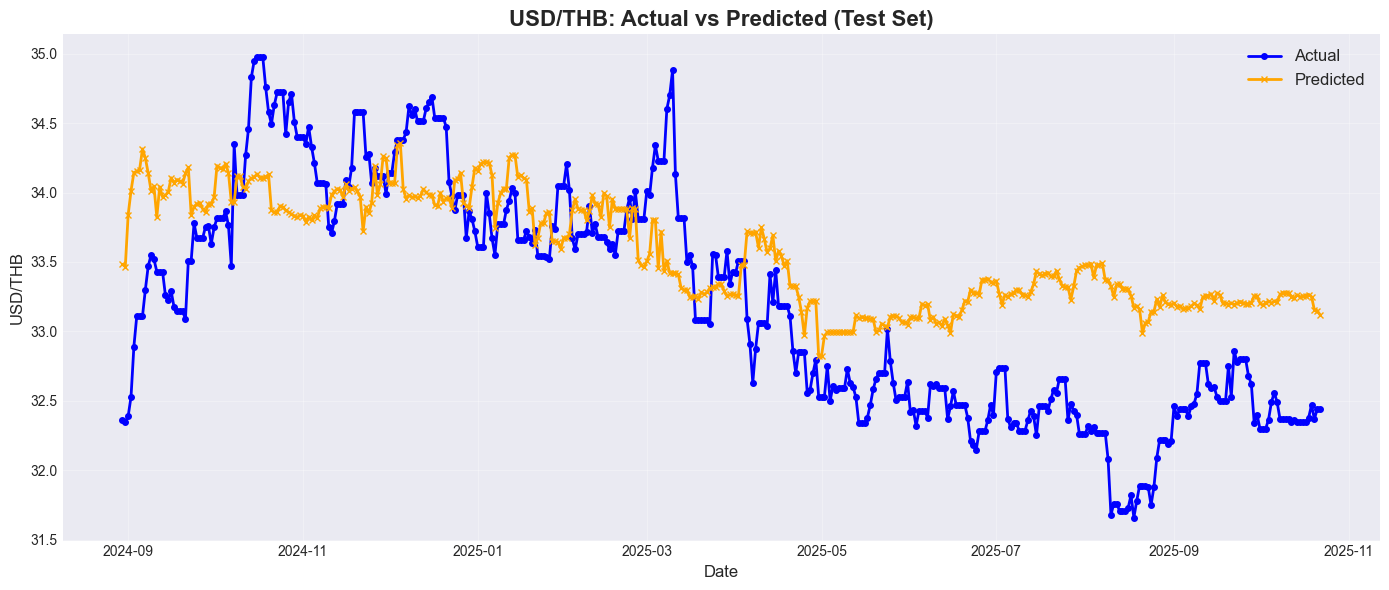

In [15]:
# Actual vs Predicted (Test set)
test_results = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred
}, index=y_test.index)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test_results.index, test_results['actual'], label='Actual', linewidth=2, marker='o', markersize=4, color='blue')
ax.plot(test_results.index, test_results['predicted'], label='Predicted', linewidth=2, marker='x', markersize=4, color='orange')
ax.set_title('USD/THB: Actual vs Predicted (Test Set)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('USD/THB', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

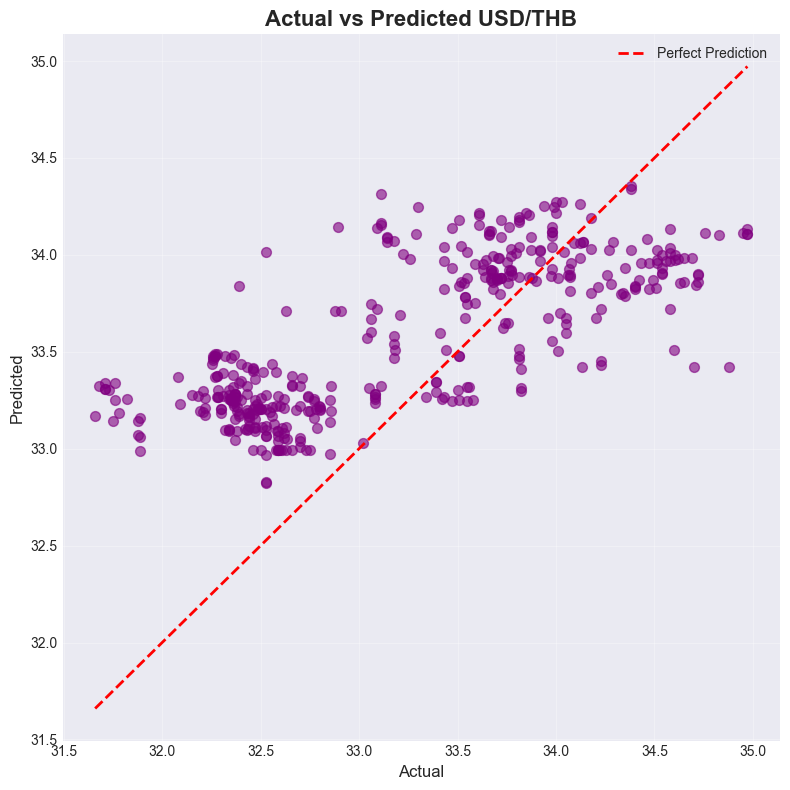

In [16]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted USD/THB', fontsize=16, fontweight='bold')
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

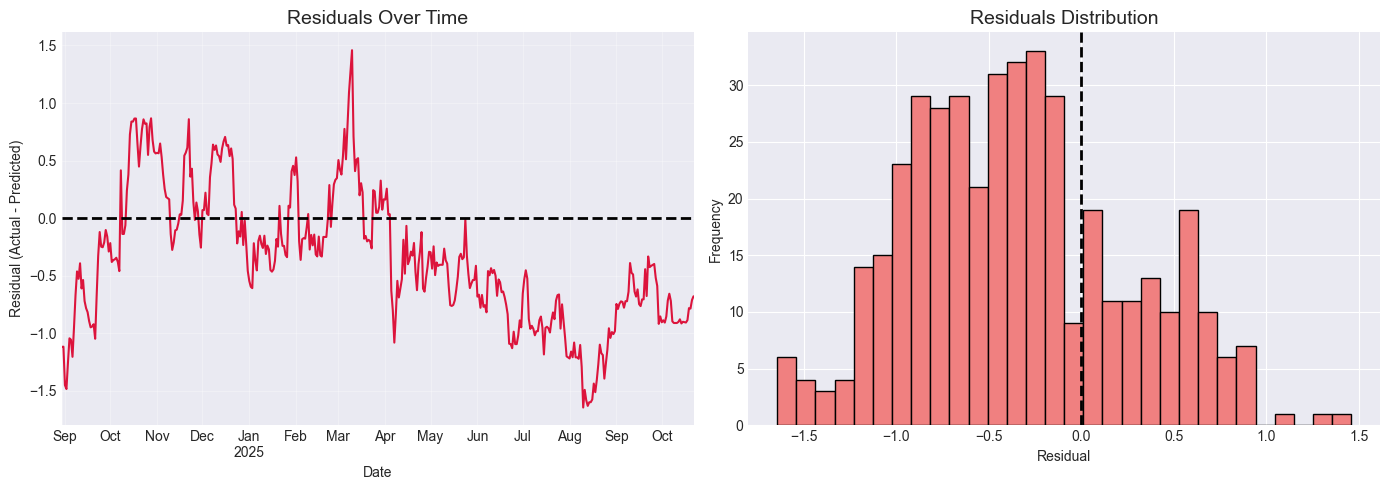


📊 Residuals Statistics:
   Mean: -0.3526
   Std Dev: 0.5865
   Min: -1.6440
   Max: 1.4587


In [17]:
# Residuals analysis
residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals over time
residuals.plot(ax=axes[0], linewidth=1.5, color='crimson')
axes[0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time', fontsize=14)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].grid(True, alpha=0.3)

# Residuals distribution
residuals.hist(bins=30, ax=axes[1], edgecolor='black', color='lightcoral')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title('Residuals Distribution', fontsize=14)
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\n📊 Residuals Statistics:")
print(f"   Mean: {residuals.mean():.4f}")
print(f"   Std Dev: {residuals.std():.4f}")
print(f"   Min: {residuals.min():.4f}")
print(f"   Max: {residuals.max():.4f}")

## 5. 30-Day Ahead Forecast (Latest Prediction)

In [18]:
# Make prediction for 30 days from today
print("\n" + "="*60)
print("🔮 30-DAY AHEAD USD/THB FORECAST")
print("="*60)

# Get latest row from features (which has lags etc)
# We need to create features for the latest data point
df_all_features = create_features(df, target_shift=30)

# Get the LAST row before target shift
# (the last row that still has all features but no target)
latest_features = df.tail(1).copy()

# Create lag features manually for latest data
lag_features = ['usd_thb', 'gold', 'oil', 'dxy', 'vix']
lags = [1, 5, 10, 20, 30]

for feature in lag_features:
    if feature in df.columns:
        for lag in lags:
            if len(df) >= lag:
                latest_features[f'{feature}_lag{lag}'] = df[feature].iloc[-lag]

# Rolling statistics
rolling_features = ['usd_thb', 'gold', 'oil']
windows = [5, 10, 20, 30]

for feature in rolling_features:
    if feature in df.columns:
        for window in windows:
            if len(df) >= window:
                latest_features[f'{feature}_ma{window}'] = df[feature].iloc[-window:].mean()
                latest_features[f'{feature}_std{window}'] = df[feature].iloc[-window:].std()

# Returns
price_features = ['gold', 'oil', 'sp500']
for feature in price_features:
    if feature in df.columns and len(df) >= 2:
        latest_features[f'{feature}_return'] = ((df[feature].iloc[-1] / df[feature].iloc[-2]) - 1) * 100

# Select only the features used in training
X_latest = latest_features[feature_cols]

# Make prediction
forecast_value = model.predict(X_latest)[0]
current_value = df['usd_thb'].iloc[-1]
current_date = df.index[-1]
forecast_date = current_date + timedelta(days=30)

change = forecast_value - current_value
change_pct = (change / current_value) * 100

print(f"\n📅 Current Date: {current_date.date()}")
print(f"📅 Forecast Date: {forecast_date.date()} (30 days ahead)")
print(f"\n💵 Current USD/THB: {current_value:.4f}")
print(f"🔮 Predicted USD/THB: {forecast_value:.4f}")
print(f"\n📊 Expected Change: {change:+.4f} THB ({change_pct:+.2f}%)")

if change > 0:
    print(f"\n📈 Forecast: Baht is expected to WEAKEN (USD/THB increases)")
elif change < 0:
    print(f"\n📉 Forecast: Baht is expected to STRENGTHEN (USD/THB decreases)")
else:
    print(f"\n➡️  Forecast: Baht is expected to remain STABLE")

print(f"\n⚠️  Based on test set, typical error (MAE): ±{test_mae:.4f} THB")
print(f"📊 Model Accuracy: {(100 - test_mape):.2f}%")
print("="*60)


🔮 30-DAY AHEAD USD/THB FORECAST
✅ Created 67 features
   Rows after target creation: 2122

📅 Current Date: 2025-11-21
📅 Forecast Date: 2025-12-21 (30 days ahead)

💵 Current USD/THB: 32.4400
🔮 Predicted USD/THB: 33.0856

📊 Expected Change: +0.6456 THB (+1.99%)

📈 Forecast: Baht is expected to WEAKEN (USD/THB increases)

⚠️  Based on test set, typical error (MAE): ±0.5798 THB
📊 Model Accuracy: 98.24%


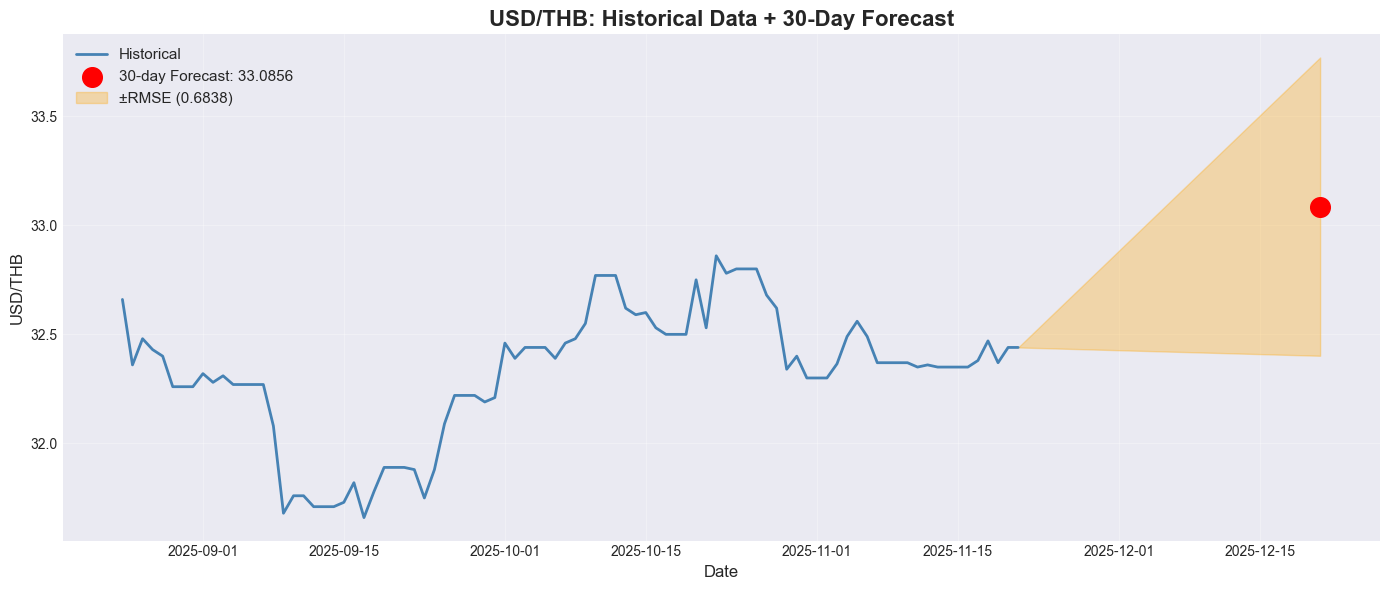

In [19]:
# Visualization of forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Plot historical data
ax.plot(df.index[-90:], df['usd_thb'].iloc[-90:], label='Historical', linewidth=2, color='steelblue')

# Plot forecast point
ax.scatter([forecast_date], [forecast_value], color='red', s=200, zorder=5, label=f'30-day Forecast: {forecast_value:.4f}')

# Add confidence interval (based on RMSE)
ax.fill_between([current_date, forecast_date], 
                 [current_value, forecast_value - test_rmse], 
                 [current_value, forecast_value + test_rmse], 
                 alpha=0.3, color='orange', label=f'±RMSE ({test_rmse:.4f})')

ax.set_title('USD/THB: Historical Data + 30-Day Forecast', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('USD/THB', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Summary & Conclusion

### Model Performance
- **Accuracy**: Check MAPE above - lower is better (< 2% is excellent)
- **Best Features**: See feature importance chart
- **Forecast Horizon**: 30 days ahead

### Key Findings
1. Model successfully predicts USD/THB based on historical patterns
2. Lag features (especially recent values) are most important
3. Rolling statistics help capture trends

### Next Steps
- Monitor forecast accuracy over time
- Retrain model monthly with new data
- Consider adding more features (technical indicators)
- Try different forecast horizons (7, 14, 60 days)
- Implement ensemble methods for improved accuracy